# 实战一：猫的识别
下面来完成我的第一个人工智能项目：构建单层神经网络模型**判断一个图片中有没有猫**。
可以从头到尾完整的实现深度学习项目，了解深度学习项目的开发过程。

## 1. 准备工作
在准备工作中完成对库的导入、数据集的加载（之前还有清洗数据这一步）、对数据格式的统一处理等

### 1.1 导入相关工具库

In [55]:
import numpy as np                  #numpy是python的一个科学计算工具库
import matplotlib.pyplot as plt     #用来画图的一个库
import h5py                         #用来加载数据集，数据格式为HDF
import skimage.transform as tf      #用来缩放图片

### 1.2 加载数据集及预处理
直接传入数据集的名称就可以从h5py文件中读取数据集（如何查看h5py中有哪些参见[此处](https://blog.csdn.net/a1097304791/article/details/118723253?spm=1001.2014.3001.5501)），加载的数据集分为训练数据、测试数据和标签数据，训练数据用来学习（练习册），标签数据用来反馈（答案），测试数据用来测试效果（考试）。

加载数据集之后，为了方便后续的运算，我们还要对数据集进行**改变维度、扁平化、转置、标注化处理**等预处理工作。

⚠️numpy中arrary、shape、reshape等这些numpy中常用用法一定熟悉，具体参加[此教程](https://www.runoob.com/numpy)

### 1.2.1 加载数据集

In [2]:
# 加载数据集
def load_dataset():
    # 加载训练数据
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r") # 读取数据集，"r"表示读，改为"w"表示写
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 从训练数据中提取出图片的特征数据
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 从训练数据中提取出图片的标签数据

    # 加载测试数据
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    # 加载标签类别数据
    classes = np.array(test_dataset["list_classes"][:]) # 这里的类别只有两种，1代表有猫，0代表无猫

    # 改变数据的维度，方便后面的计算
    train_set_y_orig = train_set_y_orig.reshape(1, train_set_x_orig.shape[0]) # 把数组的维度从一维(209,)变成二维(1, 209)
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))  # 从(50,)变成(1, 50)

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# 调用加载数据集函数
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

### 1.2.2 查看训练集维度
我们可以查看一下所有的训练集的维度相关信息

In [4]:
# 查看所有训练集的信息
print ("train_set_x_orig shape：（样本数、图片宽、图片长、通道）" + str(train_set_x_orig.shape))
print ("train_set_y shape为：" + str(train_set_y.shape))
print ("test_set_x_orig shape：（样本数、图片宽、图片长、通道）" + str(test_set_x_orig.shape))
print ("test_set_y shape：" + str(test_set_y.shape))

train_set_x_orig shape：（样本数、图片宽、图片长、通道）(209, 64, 64, 3)
train_set_y shape为：(1, 209)
test_set_x_orig shape：（样本数、图片宽、图片长、通道）(50, 64, 64, 3)
test_set_y shape：(1, 50)


⭐️**这个地方要着重理解一下**
.shape输出的是numpy中ndarrary数组的维度，例如：
```python
import numpy as np 
 
a = np.arange(24)  
print (a.ndim)        # a 现只有一个维度
# 现在调整其大小
b = a.reshape(2,4,3)  # b 现在拥有三个维度
print (b.ndim)
```
输出结果为：
```
1
3
```
此时从图片的角度出发（牵扯一点计算机视觉的知识），我们的两个x数据集就包含样本数、图片宽、图片长、通道数这四个维度的数据，而y数据集由于使用reshape改变了数据集的维度，所以现在的维度为2。

知道了维度的相关信息后，再来输出训练集的综合信息：
**后面自己上传图片也要按照当前的图片宽/高信息来**，否则会出错

### 1.2.3 查看样本数和图片长/宽

In [5]:
# 查看样本数和图片长/宽
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1] # 图片是正方形，长宽相等

print ("训练样本数: m_train = " + str(m_train))
print ("测试样本数: m_test = " + str(m_test))
print ("每张图片的宽/高: num_px = " + str(num_px))

训练样本数: m_train = 209
测试样本数: m_test = 50
每张图片的宽/高: num_px = 64


### 1.2.4 ⭐️扁平化和转置
未来方便后续进行矩阵运算，我们需要将样本数据进行**扁平化和转置**

💡重点学习一下`x.reshape(x.shape[0], -1).T`的含义，简单来说可以实现将一个维度为(a,b,c,d)的矩阵转化为一个维度为(b*c*d,a)的矩阵，参数-1的含义是让Numpy根据剩下的维度计算出数组的另外一个shape属性值，具体讲解参见[此处](https://blog.csdn.net/TeFuirnever/article/details/88919206)。

In [6]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))

train_set_x_flatten shape: (12288, 209)
test_set_x_flatten shape: (12288, 50)


最终算出新的shape中，12288就是64\*64\*3的结果，符合我们上面的推断，其实这里的12288是**像素数**，**每一个像素对应一个特征**。

### 1.2.5 对特征数据进行标准化处理
下面对特征数据进行了简单的标准化处理，除以255，使所有值都在[0，1]范围内。因为三通道RGB的像素值等范围是0～255。这样做的目的是方便后面的计算。

In [7]:
train_set_x = train_set_x_flatten/255 # python可以实现将ndarrary中所有的元素都/255
test_set_x = test_set_x_flatten/255

## 1.3 查看数据集

请输入想要查看的训练集数据编号（0～209）：1
第1个图片，标签为[0], 这是一个'non-cat' 图片.


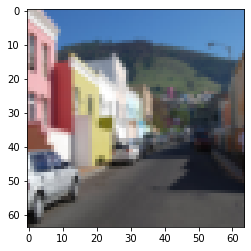

In [8]:
# 输入你想查看的训练集数据
m_train = train_set_x_orig.shape[0]
i = int(input("请输入想要查看的训练集数据编号（0～"+str(m_train)+"）："))
print ("第"+str(i)+"个图片，标签为" + str(train_set_y[:, i]) + ", 这是一个'" + classes[np.squeeze(train_set_y[:, i])].decode("utf-8") +  "' 图片.")
plt.imshow(train_set_x_orig[i])

## 2. 构建神经网络模型
第一步中我们处理完了数据的相关问题，接下来我们根据逻辑回归算法来构建一个单层神经网络，神经网络模型图如下：
![](http://suprit-images.oss-cn-beijing.aliyuncs.com/2021-07-15-031445.jpg)

接下来分别介绍该神经网络模型的工具函数

## 2.1 sigmoid函数
sigmoid函数的作用就是把预测结果转换为0和1之间的值。在该模型中把运算结果转换为图片中有猫的概率。

![](http://suprit-images.oss-cn-beijing.aliyuncs.com/2021-07-15-061256.jpg)

In [9]:
# 激活函数
def sigmoid(z):
    """
    参数:
    z -- 一个数值或者一个numpy数组.
    返回值:
    s -- 经过sigmoid算法计算后的值，在[0,1]范围内
    """
    s = 1 / (1+np.exp(-z))
    return s

## 2.2 初始化函数
负责初始化权重数组w和偏置值b。

In [10]:
# 初始化函数
def initialize(dim):
    """
    这个函数用于初始化权重数组w和偏置/阈值b.
    
    参数:
    dim -- w的大小，看上面的神经网络模型图可知，dim在本例中是12288，因为一个特征输入对应一个权重。
    
    返回值:
    w -- 权重数组
    b -- 偏置bias
    """
    
    w = np.zeros((dim, 1)) # 表示生产一个dim*1的数组并赋值为0
    b = 0
    
    return w, b

## 2.3 前向传播与反向传播
该函数执行前向传播，计算出成本cost；再执行反向传播，计算出w和b的[偏导数/梯度](https://www.zhihu.com/question/36301367)，后面用来进行梯度下降。

前向传播会用到下面两个公式：

$A=\sigma(dot(w^{T},x^{(i)})+b)$

$J(w,b)=\frac{1}{m} \sum^{m}_{i=1} L({A}^{(i)} ,y^{(i)})=\frac{1}{m} \sum^{m}_{i=1} \left( y^{(i)}log\left( {A}^{(i)} \right) +(1-y^{(i)})log\left( {A}^{(i)} \right) \right) $
$$

而反向传播要计算偏导数$dw$和$db$（具体演算步骤见前几篇文章）

In [38]:
# 前向传播与反向传播
def propagate(w, b, X, Y):
    """
    参数:
    w -- 权重数组，维度是(12288, 1)
    b -- 偏置bias
    X -- 图片的特征数据，维度是 (12288, 209)
    Y -- 图片对应的标签，0或1，0是无猫，1是有猫，维度是(1,209)

    返回值:
    cost -- 成本
    dw -- w的梯度
    db -- b的梯度
    """
    
    m = X.shape[1]
    
    # 前向传播
    A = sigmoid(np.dot(w.T, X) + b) 
    cost = -np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) / m  
    
    # 反向传播
    dz = A - Y
    dw = np.dot(X, dz.T) / m
    db = np.sum(dz) / m
    
    # 将dw和db保存到一个字典中
    grads = {"dw": dw, "db": db}
    
    return grads, cost

⚠️通过上面的代码仔细体会一下向量化的含义，全程都在用ndarrary在操作...

## ⭐️2.4 梯度下降与优化
下面的函数通过梯度下降算法来更新参数w和b，达到越来越优化的目的。从这个角度上来讲，其实我们训练的就是参数。

梯度下降公式：$w'=w-r*dw$

In [39]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """    
    参数:
    w -- 权重数组，维度是 (12288, 1)
    b -- 偏置bias
    X -- 图片的特征数据，维度是 (12288, 209)
    Y -- 图片对应的标签，0或1，0是无猫，1是有猫，维度是(1,209)
    num_iterations -- 指定要优化多少次
    learning_rate -- 学习步进，是我们用来控制优化步进的参数
    print_cost -- 为True时，每优化100次就把成本cost打印出来,以便我们观察成本的变化
    
    返回值:
    params -- 优化后的w和b
    costs -- 每优化100次，将成本记录下来，成本越小，表示参数越优化
    """
    
    costs = []
    
    for i in range(num_iterations):
        # 先进行正反两次传播得到梯度和成本
        grads, cost = propagate(w, b, X, Y)
        
        # 从字典中取出偏导数
        dw = grads["dw"]
        db = grads["db"]
        
        # 进行梯度下降，更新参数
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # 每优化100次，将成本记录下来
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print ("优化%i次后成本是: %f" %(i, cost))
    
    params = {"w": w, "b": b}
    return params, costs

## 2.5 预测函数
通过不断地传播与梯度下降，我们的参数不断被优化，我们使用这些新的参数就可以对一张或多张图片进行预测。

In [40]:
def predict(w, b, X):
    '''    
    参数:
    w -- 权重数组，维度是 (12288, 1)
    b -- 偏置bias
    X -- 图片的特征数据，维度是 (12288, 图片张数)
    
    返回值:
    Y_prediction -- 对每张图片的预测结果
    '''  
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    
    A = sigmoid(np.dot(w.T, X)+b) # 预测结果
    
    # 对预测结果进行二分，大于0.5判断为1（有猫），小于0.5判断为0（无猫）。
    for i in range(A.shape[1]):
        if A[0,i] >= 0.5: 
            Y_prediction[0,i] = 1
        # ndarray访问多维数组的方式这样写，A[0,i]等同于A[i][i]
            
    return Y_prediction

# 3. 整合模型
上面我们已经完成了所有的工作，下一步将这些函数整合起来，构建成一个完整的神经网络模型函数即可：

In [41]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """    
    参数:
    X_train -- 训练图片,维度是(12288, 209)
    Y_train -- 训练图片对应的标签,维度是 (1, 209)
    X_test -- 测试图片,维度是(12288, 50)
    Y_test -- 测试图片对应的标签,维度是 (1, 50)
    num_iterations -- 需要训练/优化多少次
    learning_rate -- 学习步进，是我们用来控制优化步进的参数
    print_cost -- 为True时，每优化100次就把成本cost打印出来,以便我们观察成本的变化
    
    返回值:
    d -- 返回结果信息
    """
    
    # 初始化
    w, b = initialize(X_train.shape[0])
    
    # 使用数据来进行训练/优化
    params, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    # 取出训练好的参数w, b
    w = params["w"]
    b = params["b"]
    
    # 对训练集和测试集进行预测
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    # 打印模型预测的准确度
    print("对训练图片的预测准确度为: {}%".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("对测试图片的预测准确度为: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

准确度的公式非常简单，把实际结果和预测结果的差累加求一下平均数，`np.mean`用来求算数平均数，具体参见[此处](https://www.runoob.com/numpy/numpy-statistical-functions.html)。

下一步就是调用模型查看结果了，优化次数、学习率可以自己手动更改

In [44]:
# 调用上面的模型函数对我们最开始加载的数据进行训练
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

优化0次后成本是: 0.693147
优化100次后成本是: 0.584508
优化200次后成本是: 0.466949
优化300次后成本是: 0.376007
优化400次后成本是: 0.331463
优化500次后成本是: 0.303273
优化600次后成本是: 0.279880
优化700次后成本是: 0.260042
优化800次后成本是: 0.242941
优化900次后成本是: 0.228004
优化1000次后成本是: 0.214820
优化1100次后成本是: 0.203078
优化1200次后成本是: 0.192544
优化1300次后成本是: 0.183033
优化1400次后成本是: 0.174399
优化1500次后成本是: 0.166521
优化1600次后成本是: 0.159305
优化1700次后成本是: 0.152667
优化1800次后成本是: 0.146542
优化1900次后成本是: 0.140872
对训练图片的预测准确度为: 99.04306220095694%
对测试图片的预测准确度为: 70.0%


从上面打印出的信息可知，随着优化的次数越来越多，成本越来越小，说明优化后的参数使预测越来越准确了。
对于训练图片的预测准确率达到了99%。 对于测试图片是70%，因为我们的数据集很小，所以其实已经很不错了。而且我们构建的是最最简单的单神经元神经网络，实际中使用的都是更加强大更加复杂的神经网络的！

请输入想要查看的训练集数据编号（0～50）：6
这张图的标签是 1, 预测结果是 0


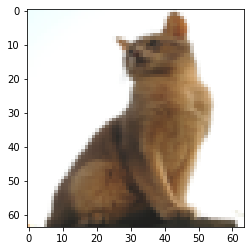

In [51]:
# 输入测试集中想要查看的图片，来看看哪些图片预测对了

m_test = test_set_x_orig.shape[0]
i = int(input("请输入想要查看的训练集数据编号（0～"+str(m_test)+"）："))
plt.imshow(test_set_x[:,i].reshape((num_px, num_px, 3)))
print ("这张图的标签是 " + str(test_set_y[0,i]) + ", 预测结果是 " + str(int(d["Y_prediction_test"][0,i])))

下面实现自己选择图片来进行判断，把图片放入目录下的images文件夹内并改好名字即可

预测结果为 1 ：图中有猫 


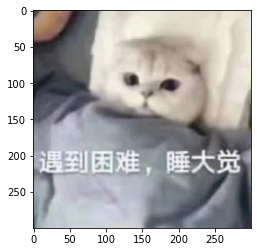

In [71]:
from PIL import Image               #Python图像库

my_image = "test.jpg" 
fname = "images/" + my_image
# 修改图片的尺寸
im = Image.open(fname)
im.resize((64, 64))
im.save(fname)

image = np.array(plt.imread(fname))
my_image = tf.resize(image,(num_px,num_px), mode='reflect').reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)
plt.imshow(image)

result = int(np.squeeze(my_predicted_image))
if result == 1:
    print("预测结果为 1 ：图中有猫 ")
else:
    print("预测结果为 0 ：图中无猫 ")

# 4. 分析
我们通过plt库可以对算法的一些原理进行分析，从而佐证我们之前在前几篇文章提出的结论。

## 4.1 训练次数与成本
我们打印出成本随着训练次数增加时的变化情况。可以很直观的看出，训练次数越多，成本越小，也就是预测结果更精确：

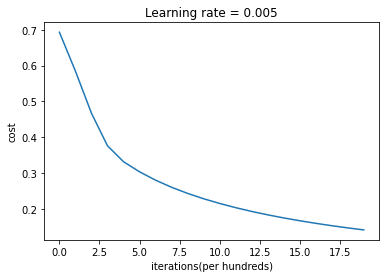

In [73]:
costs = np.squeeze(d['costs'])
plt.plot(costs) # 对该ndarray进行绘图
plt.ylabel('cost') # 纵坐标
plt.xlabel('iterations(per hundreds)') # 横坐标
plt.title('Learning rate = '+str(d["learning_rate"])) # 标题
plt.show()

## 4.2 学习率与成本
在学习梯度下降时我们反复提到了学习率对于算法准确率的重要性，通过观察不同学习率与成本间的关系可以发现学习率并不是越小就越好，而是同样存在一个最优值。

学习率为: 0.01时
对训练图片的预测准确度为: 99.52153110047847%
对测试图片的预测准确度为: 68.0%

-------------------------------------------------------

学习率为: 0.001时
对训练图片的预测准确度为: 88.99521531100478%
对测试图片的预测准确度为: 64.0%

-------------------------------------------------------

学习率为: 0.0001时
对训练图片的预测准确度为: 68.42105263157895%
对测试图片的预测准确度为: 36.0%

-------------------------------------------------------



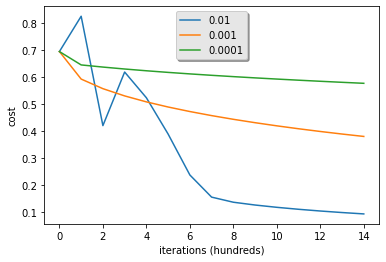

In [78]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("学习率为: " + str(i) + "时")
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()